# 토픽 모델링으로 주제 찾기
문서분류: 텍스트의 내용을 파악해 무엇인가를 예측
토픽 모델링: 예측보다는 내용의 분석 자체를 목적으로 하는 기법

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 사이킷런을 이용한 토픽 모델링

### 데이터 준비
20 뉴스그룹 데이터 - 6개 카테고리 선택

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space',
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [ ]:
# colab에서 위 셀 http error 발생시 실행
# import pickle
# with open("/content/drive/MyDrive/TextMining_Code_Data/Data/newsgroups_train.pickle","rb") as fr:
#     newsgroups_train = pickle.load(fr)
# print('#Train set size:', len(newsgroups_train.data))
# print('#Selected categories:', newsgroups_train.target_names)

In [ ]:
# 카운트 벡터 생성 - 사이킷런의 LDA 라이브러리는 카운트 벡터를 입력으로 사용
# 문서분류에서는 단어 수를 제한하지 않을 때 가장 좋은 성능을 보였으나 수행 시간을 고려해 처음에 사용한 2,000개를 그대로 적용

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', # [\w']{3,} : 대소문자 알파벳, 숫자, 언더스코어,', 3글자이상
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

### LDA 토픽 모델링 실행

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수, 일단 10으로 설정, 최적값 결정 방법은 뒤에서~
                                max_iter=5,   # 알고리즘 최대 반복 횟수, 기본값은 10
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                # topic_word_prior(베타): 토픽의 사전 단어분포를 결정, 기본값은 1/n_components
                                # doc_topic_prior(알파): 문서의 사전 토픽분포를 결정, 기본값은 1/n_components
                                # 토픽모델링으로 유명한 논문에서 베타=0.1, 알파=50/n_components 로 토픽수를 10~1,000으로 테스트
                                # 알파, 베타에 대한 정해진 답은 없음, 위 근처에서 적절한 값 찾아보기를 권함

                                learning_method='online',   # 'batch' 가 'online'에 비해 성능이 더 좋은 대신 느림
                                n_jobs= -1, # 실행시 사용 processor(코어) 수, 값을 주지 않으면 1개, -1이면 가능한 모든 프로세서 사용
                                random_state=0)  # 랜덤 시드를 지정해 재실행 및 확인이 가능하도록 설정

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)  # 각 문서별 토픽 분포(쎄타)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)   # 열에 대한 평균은 문서 전체에 나타난 토픽 평균 분포

print('#shape of topic word distribution:', lda.components_.shape)
#토픽의 단어 분포(피): 각 토픽에 대한 카운트 벡터에서 사용한 2000 단어의 비중

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.901 0.007 0.029 0.008 0.007 0.008 0.008 0.007 0.007 0.019]
#Sum of topic weights of documents: [0.09  0.083 0.081 0.114 0.117 0.136 0.085 0.072 0.072 0.151]
#shape of topic word distribution: (10, 2000)


In [ ]:
print(lda.components_[0])  # 첫번째 토픽의 2,000개 단어 비중, 단어 순서는 feature_names 순
print(len(lda.components_[0]))   # 토픽을 이루는 2,000개 단어

[0.649 0.123 0.273 ... 0.102 0.102 0.101]
2000


In [ ]:
# 토픽의 내용을 파악하기 위해 2,000개 단어의 비중을 모두 들여다보는 것은 거의 불가능하므로
# 대개 상위 10~20개 단어 비중을 살펴봄

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지, n_top_words =10이면 -n_top_words - 1은 -11
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

# 분석 결과를 보고 토픽이 제대로 분류되었는지 확인하는 것은 분석자의 몫
# 토픽 제목 설정도 분석자가 판단 - 1번 토픽 graphics, 2번 토픽 space ...
# 혼란도나 토픽 응집도 수치가 높아도 토픽을 해석하기 어렵다면 좋은 결과라고 하기 어려움

Topic #0: com, morality, keith, article, sgi, think, sandvik, caltech, objective, moral
Topic #1: image, graphics, file, files, ftp, available, software, use, data, pub
Topic #2: space, access, launch, earth, orbit, digex, lunar, shuttle, satellite, com
Topic #3: article, com, just, like, don't, university, i'm, nntp, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, posting, nntp, host, thanks, bit, university, ibm, know
Topic #6: nasa, gov, university, host, posting, nntp, ___, distribution, center, washington
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, problem, floppy
Topic #8: key, public, mail, faq, message, pgp, group, des, posting, university
Topic #9: god, people, don't, jesus, just, believe, say, does, think, know



In [ ]:
### check!
test = np.array([3, 4, 1, 8, 5, 9, 7])
print(test.argsort())   # [2 0 1 4 6 3 5]  non-decreasing order
print(test.argsort()[:-4:-1])  # [2 0 1 4 6 3 5] 에서 역순으로 4 번째 이전까지

[2 0 1 4 6 3 5]
[5 3 6]


### 최적의 토픽 수 선택하기
토픽모델링에서 가장 중요한 하이퍼 파라미터는 토픽의 수
토픽 수를 결정하기 위해 다양한 토픽 수를 적용한 모형에 대한 혼란도와 토픽 응집도 계산
사이킷런은 혼란도만 공식적으로 제공하므로 혼란도(perplexity)를 계산하고 그래프를 통해 적절한 값 선택




n_components: 6, perplexity: 1063.362
n_components: 7, perplexity: 1045.636
n_components: 8, perplexity: 1015.561
n_components: 9, perplexity: 1016.494
n_components: 10, perplexity: 1028.560
n_components: 11, perplexity: 1036.692
n_components: 12, perplexity: 1032.437
n_components: 13, perplexity: 1038.319
n_components: 14, perplexity: 1040.664
n_components: 15, perplexity: 1046.556


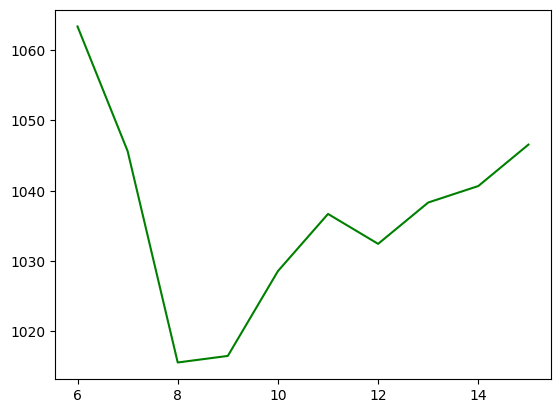

n_components with minimum perplexity: 8


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1,   # start 토픽 수 시작 값, end 토픽수 끝 값
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter,
                                        topic_word_prior= topic_word_prior,
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')   # green line
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=6, end=15))

In [ ]:
lda = LatentDirichletAllocation(n_components = 9, # 위에서 찾은 최저 perplexity 추출할 topic의 수를 지정
                                max_iter=20,
                                topic_word_prior= 0.1,
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, file, available, ftp, mail, data, files, graphics, information, internet
Topic #1: space, nasa, gov, center, ___, orbit, earth, research, jpl, mission
Topic #2: com, keith, morality, caltech, sgi, objective, article, think, moral, don't
Topic #3: com, jesus, article, just, god, know, john, good, don't, world
Topic #4: people, god, don't, does, think, say, believe, just, way, like
Topic #5: drive, scsi, disk, hard, ide, controller, bus, card, drives, bit
Topic #6: space, access, article, just, year, com, launch, like, digex, henry
Topic #7: key, encryption, clipper, chip, government, com, keys, security, use, public
Topic #8: com, posting, university, host, nntp, thanks, i'm, article, know, help



## 2. Gensim을 이용한 토픽 모델링
Gensim: Word2Vec으로 알려졌고 토픽 모델링을 포함해 의미적인 자연어처리를 위한 다양한 라이브러리 제공


### Gensim 사용법과 시각화

In [ ]:
#!pip install --upgrade gensim

In [ ]:
# 필요한 library들을 import

from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의

import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from gensim.corpora.dictionary import Dictionary

# gensim은 내부 모듈에서 매개변수 사용시, 텍스트의 토큰화 결과를 texts,
# 이 토큰화 결과를 doc2bow()로 변환한 결과를 corpus(카운트 벡터) 로 지칭

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)  # 토큰화 결과로부터 토큰과 gensim 모듈이 내부적으로 사용하는 id를 매칭하는 사전 생성
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)  # 사이킷런과 비교하면 keep_n=max_features, min_df=no_below, max_df=no_above
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [ ]:
from gensim.models import LdaModel

num_topics = 10
passes = 5    # passes: max_iter

# %time : 주피터 노트북 명령어로 해당 문장을 실행하는데 소요된 시간을 출력
%time model = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, num_topics=num_topics, random_state=7)
                       # dictionary: 토큰화 결과로부터 토큰과 gensim 모듈이 내부적으로 사용하는 id를 매칭하는 사전
                       # passes: max_iter

CPU times: user 18.2 s, sys: 82.1 ms, total: 18.3 s
Wall time: 19.3 s


In [ ]:
# 사이킷런은 각 토픽의 상위 비중 단어를 보기 위해 함수를 만들었지만 gensim은 print_topics() 메서드 지원
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [ ]:
# get_document_topics() 에서 minimum_probability 이상의 토픽만 출력하도록 설정 가능
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])  # corpus: 문서들의 카운트 벡터

#topic distribution of the first document:  [(0, 0.72576934), (8, 0.2699505)]


In [ ]:
# pyLDAvis ; gensim의 토픽모델링 결과를 시각화하는 패키지
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.5 MB/s eta 0:00:00


< pyLDAvis: gensim의 토픽모델링 결과를 시각화하는 패키지 >


토픽은 단어 개수의 차원. 이를 2 차원으로 압축하기 위해서는 차원 축소 방법 사용
LDAvis 는 Principal Component Analysis (PCA) 를 이용하여 n_terms 차원의 벡터들을 2 차원으로 압축
원의 크기는 토픽의 비중을 나타내며 토픽 간의 거리는 토픽의 유사도로 이해할 수 있음


- **salience** : 한 토픽의 키워드라면, 각 토픽에 속한 많은 문서들에서 등장해야, 즉 P(w|t)가 커야
- **discriminative power** : LDAvis 에서는 P(w|t)를 P(w)로 나눔. 한 토픽에서 자주 등장하는 단어라 하더라도 본래 자주 등장하는 단어라면 그 중요도를 낮추겠다는 의미, Inverse Document Frequency (IDF) 의 관점과도 비슷, 최고의 discriminative power 를 지닌 단어는 infrequent terms 일 가능성이 높음.


=> LDAvis 에서는 negative correlation 관계에 있는 salience, discriminative power 두 관점의 중요도를 사람이 직접 정할 수 있도록 함.
λ([0, 1])에 따라 키워드 랭킹 계산.


**relevance**: λ\*P(w|t)+(1-λ)\*P(w|t)/P(w)

P(w|t): Estimated term frequency within the selected topic
P(w): Overall term frequency

λ=1: 토픽 별로 가장 자주 등장하는 단어들을 우선적으로 키워드로 선택, λ가 0 에 가까울수록 토픽 간에 차이가 많이 나는 단어를 선택한다는 의미


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(model, corpus, dictionary)
# By default, pyLDAvis sorts the topics by topic proportion 코퍼스 토픽 비중 => gensim 토픽 순서와 pyLDAvis 토픽 순서가 다를 수 있음

lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)  # 순서는 같은데 번호는 1씩 차이(pyLDAvis는 1번 토픽부터~)

lda_viz


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.040786 -0.129974       1        1   4.524071
1      0.182144  0.063761       2        1   3.326637
2     -0.005359 -0.091972       3        1   4.051827
3     -0.027374 -0.054949       4        1   8.494165
4      0.021828  0.007495       5        1   9.298365
5     -0.065990  0.123620       6        1  14.522776
6     -0.072783 -0.094709       7        1   9.118869
7     -0.138320  0.043609       8        1  11.020437
8      0.137200  0.040249       9        1  22.655416
9     -0.072133  0.092872      10        1  12.987437, topic_info=         Term         Freq        Total Category  logprob  loglift
538     space  1487.000000  1487.000000  Default  30.0000  30.0000
20        com  3752.000000  3752.000000  Default  29.0000  29.0000
834       key  1316.000000  1316.000000  Default  28.0000  28.0000
1551     scsi   741.000000   741.000000  Default  27.0000  27.0000
70    posting  1723.000000  1723.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
62        one   230.754460  2768.846194  Topic10  -5.2423  -0.4436
481       new   182.034902   963.561114  Topic10  -5.4794   0.3748
505   program   170.689998   664.560000  Topic10  -5.5438   0.6819
87     system   173.647916  1370.838289  Topic10  -5.5266  -0.0250
9     article   167.823404  2031.040414  Topic10  -5.5607  -0.4522

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      6  0.069013      128
1359      8  0.878342      128
1359      9  0.006274      128
1359     10  0.037643      128
153       1  0.012492     1993
...     ...       ...      ...
343       8  0.033591    years
343       9  0.179155    years
343      10  0.251936    years
704      10  0.991487      zoo
705      10  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### 혼란도와 토픽 응집도를 이용한 최적값 선택
gensim은 혼란도와 토픽 응집도를 계산할 수 있는 모듈 모두 제공


In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
# 응집도를 계산하는 척도: u_mass => corpus 필요, c_v, c_uci, cnpmi => texts 필요
# 가장 속도가 빠른 척도는 u_mass
coherence = cm.get_coherence()
print(coherence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-1.7493528544065975


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -7.035, coherence: -1.701


num_topics: 7, perplexity: -7.023, coherence: -1.735


num_topics: 8, perplexity: -7.023, coherence: -1.547


num_topics: 9, perplexity: -7.007, coherence: -1.891


num_topics: 10, perplexity: -6.996, coherence: -1.888


num_topics: 11, perplexity: -7.027, coherence: -2.164


num_topics: 12, perplexity: -7.019, coherence: -2.018


num_topics: 13, perplexity: -7.025, coherence: -2.255


num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


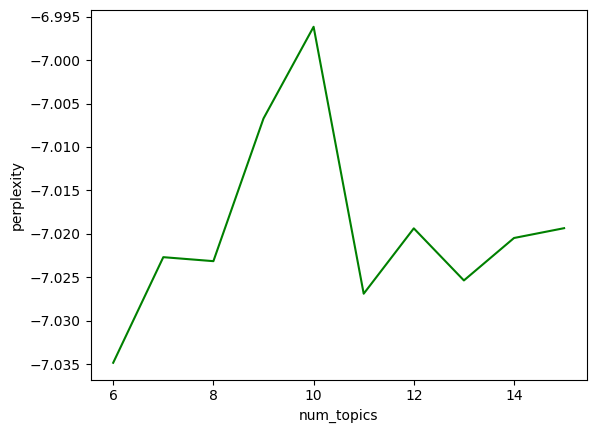

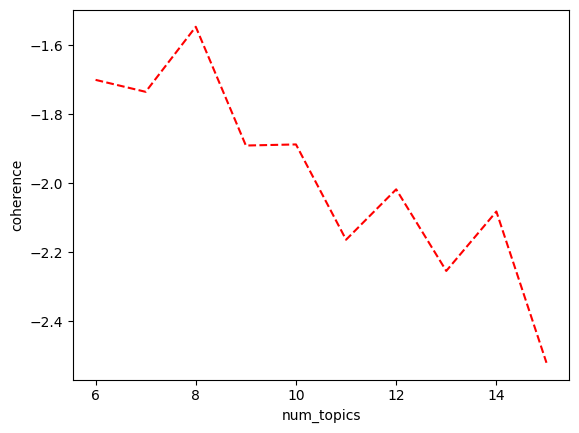

In [ ]:
# 지정된 토픽 수의 범위에 따라 LDA 모델을 학습하고 이 모델에 대해 혼란도와 토픽 응집도를 계산해 그래프로 그리는 함수 구현

def show_coherence(corpus, dictionary, start=6, end=15):  # start: 시작 토픽 수, end: 끝 토픽 수
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                # chunksize: 한 번에 처리하는 문서 갯수. 시스템 메모리가 감당한다면 클수록 속도 빨라. 한 번에 모든 문서를 처리할 수도 있음.
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)  # 혼란도 계산, corpus 필요
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus,
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

# 혼란도는 토픽 수 6, 응집도는 토픽 수 8에서 가장 좋음 => 토픽 모델링을 최적화하는 것이 쉽지 않음
# => 결정은 분석가의 몫. 둘 다 해보고 해석이 더 좋은 것을 선택할 수도 있음.

## 3. 토픽트렌드로 시간에 따른 주제의 변화 알아내기
토픽 트렌드는 주어진 시간 동안 토픽들의 비중이 어떻게 변화했는지를 봄으로써 주요 토픽의 추이를 분석
모든 문서에 생성 날짜가 있다면, 각 월의 토픽 분포 평균을 계산함으로써 매달 토픽이 어떻게 변화했는지를 볼 수 있음
다양한 분야에서 연구 주제의 변화, 사람들의 관심의 변화 등을 알아내는 데 활용


깃허브에 공개된 청와대 국민청원 사이트의 만료된 청원 데이터 모음 사용
속도를 위해 전체 데이터 중 5%만 임의추출한 petition_sampled.csv 를 다운로드해 실습 디렉터리 밑에 생성한 Data 폴더에 저장하고 다음과 같이 분석

1: https://github.com/akngs/petitions

In [ ]:
!pip install wget

import os
import wget
import ssl

data_dir = 'Data'
url = 'https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv'
ssl._create_default_https_context = ssl._create_unverified_context   # ssl 인증 에러를 방지하기 위한 설정
# ssl(secure sockets layer): 인터넷을 통해 전송되는 데이터의 인증, 암호화, 복호화를 위한 웹 브라우저 및 서버용 프로토콜

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

wget.download(url, data_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=30094840448e8616de5557386c0c465264c2dc7665b2d95afcce6f5d333f20fb
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'Data/petition_sampled.csv'

In [ ]:
import pandas as pd

df = pd.read_csv("./Data/petition_sampled.csv") #read data
print(df.iloc[[2]])   # index 2에 해당하는 행 추출

df.columns

# start: 청원 시작날짜, content: 청원 내용

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   article_id       start         end  answered  votes category  \
2         136  2017-08-20  2017-11-18         0      4    육아/교육   

                                  title  \
2  고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!   

                                             content  
2  저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...  


Index(['article_id', 'start', 'end', 'answered', 'votes', 'category', 'title',
       'content'],
      dtype='object')

In [ ]:
# konlpy 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# 보통 토픽 모델링은 명사를 대상으로 함(여기에서는 두 자 이상의 명사만 사용. 분석자의 판단에 따라 형용사, 동사를 추가할 수도 있음.

from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      max_df=0.5, min_df = 5,
                      max_features = 1000) #적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(18077, 1000)


In [ ]:
#  토픽 수 최적값 찾는 과정은 생략하고 15개로 설정

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names_out(), 15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2.63 s, sys: 375 ms, total: 3.01 s
Wall time: 2min 11s
Topic #0: 사람, 생각, 병원, 대통령, 피해자, 국민, 사건, 정말, 가족, 나라, 환자, 자신, 인간, 지금, 의사
Topic #1: 북한, 우리, 한국, 대통령, 정부, 국민, 대한민국, 미국, 일본, 문재인, 국가, 문제, 생각, 나라, 우리나라
Topic #2: 아이, 부모, 어린이집, 생각, 교사, 엄마, 우리, 유치원, 자녀, 가정, 동물, 출산, 아빠, 문제, 지원
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 사찰, 생각, 외국인, 이용, 노인, 사회, 나이, 범죄, 사람
Topic #4: 정부, 주택, 정책, 국민, 부동산, 서민, 아파트, 나라, 대통령, 세금, 지금, 사람, 투기, 집값, 임대
Topic #5: 일자리, 기업, 근무, 정부, 생각, 근로자, 지원, 임금, 최저임금, 시간, 정책, 회사, 직원, 대기업, 고용
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 청와대, 세금, 반대, 생각, 건강, 동의, 제도, 대통령, 답변, 국가
Topic #7: 관리, 내용, 대한, 조사, 관련, 판결, 공사, 사실, 업무, 판사, 확인, 해당, 주민, 발생, 민원
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 문제, 교사, 선생님, 시간, 제도, 위해, 고등학교
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 방송, 국민, 소득, 가입, 국가, 기초, 보험료, 공단, 군인, 수급
Topic #10: 여성, 공무원, 사회, 대한민국, 생각, 남성, 사람, 남자, 행정, 국민, 나라, 여자, 의무, 군대, 국가
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 수사, 만행, 범죄자, 경찰서, 부정부패, 검찰, 살인마
Topic #12: 처벌, 피해자, 사건, 차량, 사고, 피해, 가해자, 범죄, 경우, 대한, 기사,

In [ ]:
# 문서별 토픽 분포를 데이터 프레임으로 만들고
# 토픽 트렌드를 월 단위로 분석하기 위해 각 문서의 날짜(start) 정보를 월 단위로 변환하고
# 토픽 분포 데이터 프레임과 start 정보를 결합

trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15
0,0.000307,0.000307,0.000307,0.058007,0.180857,0.000307,0.000307,0.757449,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307
1,0.000813,0.000813,0.171417,0.000813,0.000813,0.057132,0.000813,0.000813,0.000813,0.140125,0.063464,0.000813,0.000813,0.000813,0.559732
2,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.979710,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449
3,0.043334,0.642207,0.000227,0.000227,0.000227,0.253378,0.000227,0.000227,0.000227,0.000227,0.032685,0.000227,0.000227,0.000227,0.026129
4,0.000447,0.392787,0.000447,0.000447,0.000447,0.024788,0.253386,0.021899,0.000447,0.000447,0.267475,0.000447,0.035637,0.000447,0.000447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18072,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.533333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
18073,0.127943,0.612412,0.001235,0.001235,0.001235,0.001235,0.034545,0.001235,0.001235,0.001235,0.001235,0.080400,0.132354,0.001235,0.001235
18074,0.000694,0.045435,0.000694,0.012106,0.000694,0.000694,0.000694,0.716172,0.000694,0.000694,0.000694,0.000694,0.000694,0.000694,0.218648
18075,0.003030,0.791890,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.168716,0.003030,0.003030,0.003030,0.003030


In [ ]:
df.start.map(lambda x: x[:7])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        2017-08
1        2017-08
2        2017-08
3        2017-08
4        2017-08
          ...   
18072    2018-12
18073    2018-12
18074    2018-12
18075    2018-12
18076    2018-12
Name: start, Length: 18077, dtype: object

In [ ]:
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.058007,0.180857,0.000307,0.000307,0.757449,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.171417,0.000813,0.000813,0.057132,0.000813,0.000813,0.000813,0.140125,0.063464,0.000813,0.000813,0.000813,0.559732,2017-08
2,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.979710,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.043334,0.642207,0.000227,0.000227,0.000227,0.253378,0.000227,0.000227,0.000227,0.000227,0.032685,0.000227,0.000227,0.000227,0.026129,2017-08
4,0.000447,0.392787,0.000447,0.000447,0.000447,0.024788,0.253386,0.021899,0.000447,0.000447,0.267475,0.000447,0.035637,0.000447,0.000447,2017-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18072,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.533333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,2018-12
18073,0.127943,0.612412,0.001235,0.001235,0.001235,0.001235,0.034545,0.001235,0.001235,0.001235,0.001235,0.080400,0.132354,0.001235,0.001235,2018-12
18074,0.000694,0.045435,0.000694,0.012106,0.000694,0.000694,0.000694,0.716172,0.000694,0.000694,0.000694,0.000694,0.000694,0.000694,0.218648,2018-12
18075,0.003030,0.791890,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.168716,0.003030,0.003030,0.003030,0.003030,2018-12


In [ ]:
trend_data.iloc[:5, -5:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.559732,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.026129,2017-08
4,0.000447,0.035637,0.000447,0.000447,2017-08


In [ ]:
trend = trend_data.groupby(['start']).mean()   # start 년월이 같은 문서들끼리 그룹핑하여 토픽 분포의 평균 산출
trend.iloc[:5, -5:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.043216,0.015766,0.025389,0.024661,0.110004
2017-09,0.042948,0.023563,0.104047,0.019750,0.040786
2017-10,0.083816,0.053574,0.064864,0.032247,0.097858
2017-11,0.045919,0.045047,0.221295,0.045477,0.048018
2017-12,0.059587,0.027359,0.075098,0.050710,0.076128


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15']


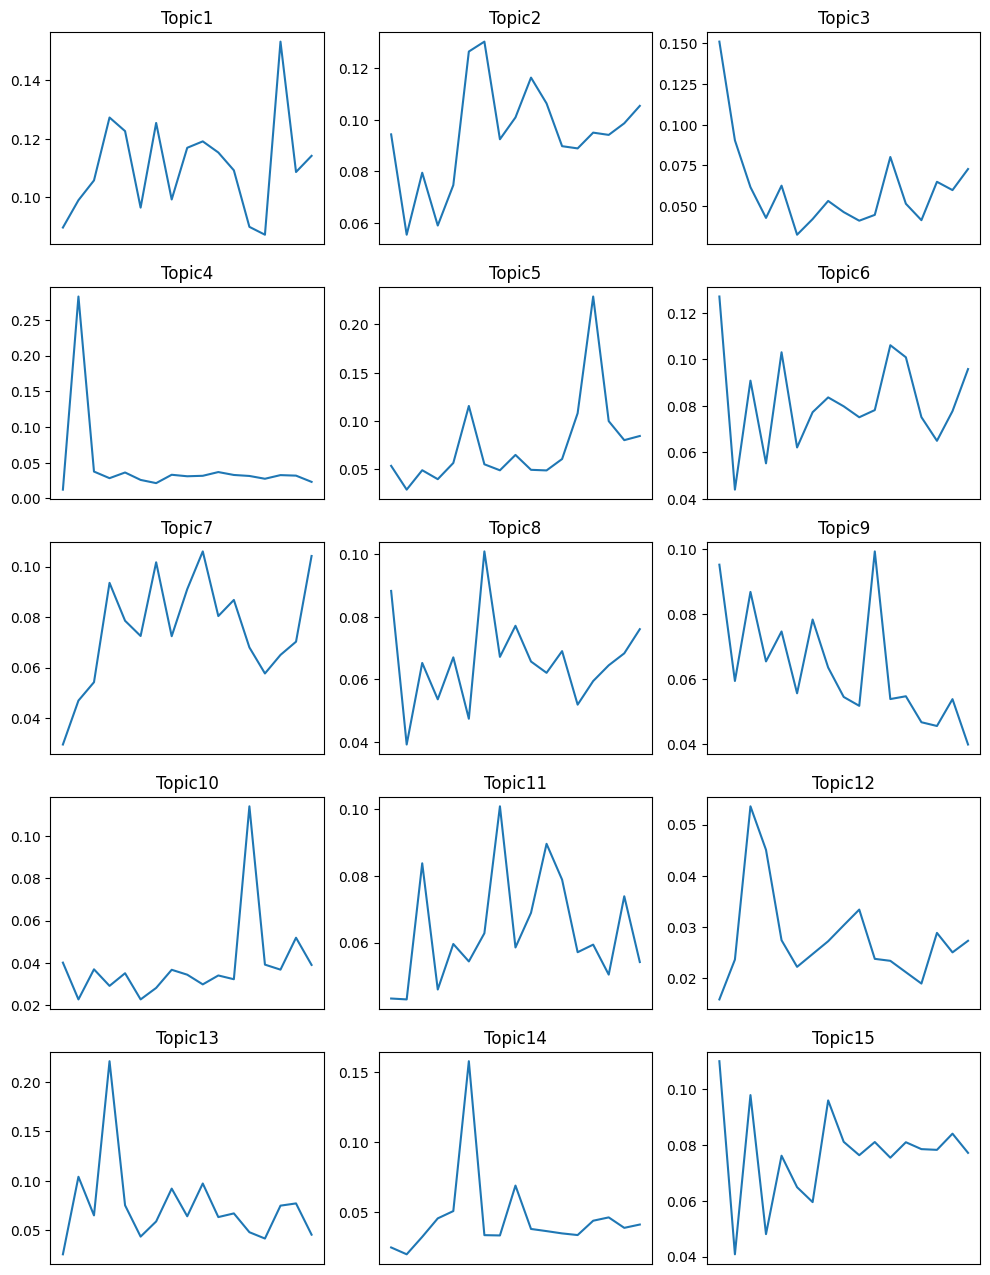

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) # sharex='col': x축 범위를 col 방향으로 공유(share), sharey 등

# matplotlib의 rcParams 설정을 활용하면, 차트의 크기와 선의 색, 두께등의 기본 값을 설정 가능
# rc: "runtime configuration"
parameters = {'ytick.labelsize': 11}
plt.rcParams.update(parameters)

print(trend.columns.tolist())
# print(axes.ravel())

for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

# cold topic: 시간이 흐를수록 비중이 줄어드는 토픽. topic 3
# hot topic: 시간이 흐를수록 비중이 높아지는 토픽, topic 7

In [ ]:
### check!

import numpy as np

x = np.arange(12).reshape(3, 4)

print(x)

print(np.ravel(x, order='C')) # by default  C 언어와 같은 순서대로 펼침

print(axes.shape)
print(axes.ravel().shape)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
(5, 3)
(15,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### check!

print(list(zip("abc", [1, 2, 3])))

list(zip([1, 2, 3], [4, 5, 6]))


[('a', 1), ('b', 2), ('c', 3)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 4), (2, 5), (3, 6)]

In [ ]:

topics = model.get_document_topics(corpus)

trend_data = pd.DataFrame(topics, columns=['Topic'+str(i) for i in range(1,11)])
trend_data = pd.DataFrame(topics)
trend_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,"(0, 0.7257757)","(8, 0.26994422)",None,None,None,None,None,None,None,None
1,"(5, 0.2871542)","(8, 0.35642126)","(9, 0.32724237)",None,None,None,None,None,None,None
2,"(0, 0.019264324)","(5, 0.08716246)","(6, 0.8826293)",None,None,None,None,None,None,None
3,"(3, 0.9774903)",None,None,None,None,None,None,None,None,None
4,"(8, 0.98635966)",None,None,None,None,None,None,None,None,None


# 텍스트 클러스터링
20 뉴스그룹 데이터 중 세 가지 카테고리

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram, fcluster
from matplotlib import pyplot as plt

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['talk.religion.misc', 'comp.graphics', 'sci.space']

# categories = ['talk.religion.misc']


#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)




print(newsgroups_train.keys())
print(newsgroups_train.filenames[:3])

def file_ids(s):
    return '_'.join(s.split('\\')[6:])


fileids = list(map(file_ids, newsgroups_train.filenames))
print(fileids [:3])

import pandas as pd

print('target 클래스의 값과 분포도\n',pd.Series(newsgroups_train.target).value_counts().sort_index())
print('target 클래스의 이름들\n',newsgroups_train.target_names)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
['/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60893'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/61136'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/talk.religion.misc/83681']
['', '', '']
target 클래스의 값과 분포도
 0    584
1    593
2    377
Name: count, dtype: int64
target 클래스의 이름들
 ['comp.graphics', 'sci.space', 'talk.religion.misc']
#Train set size: 1554
#Selected categories: ['comp.graphics', 'sci.space', 'talk.religion.misc']


In [ ]:
# check: 파이썬 내장함수 map

def two_times(x): return x*2

list(map(two_times, [1,2,3,4]))

[2, 4, 6, 8]

In [ ]:
tfidf = TfidfVectorizer(token_pattern=r"[\w']{3,}", max_features=2000, stop_words='english', min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform(newsgroups_train.data)

X_train_tfidf.shape

(1554, 2000)

## 1. 계층적 군집화

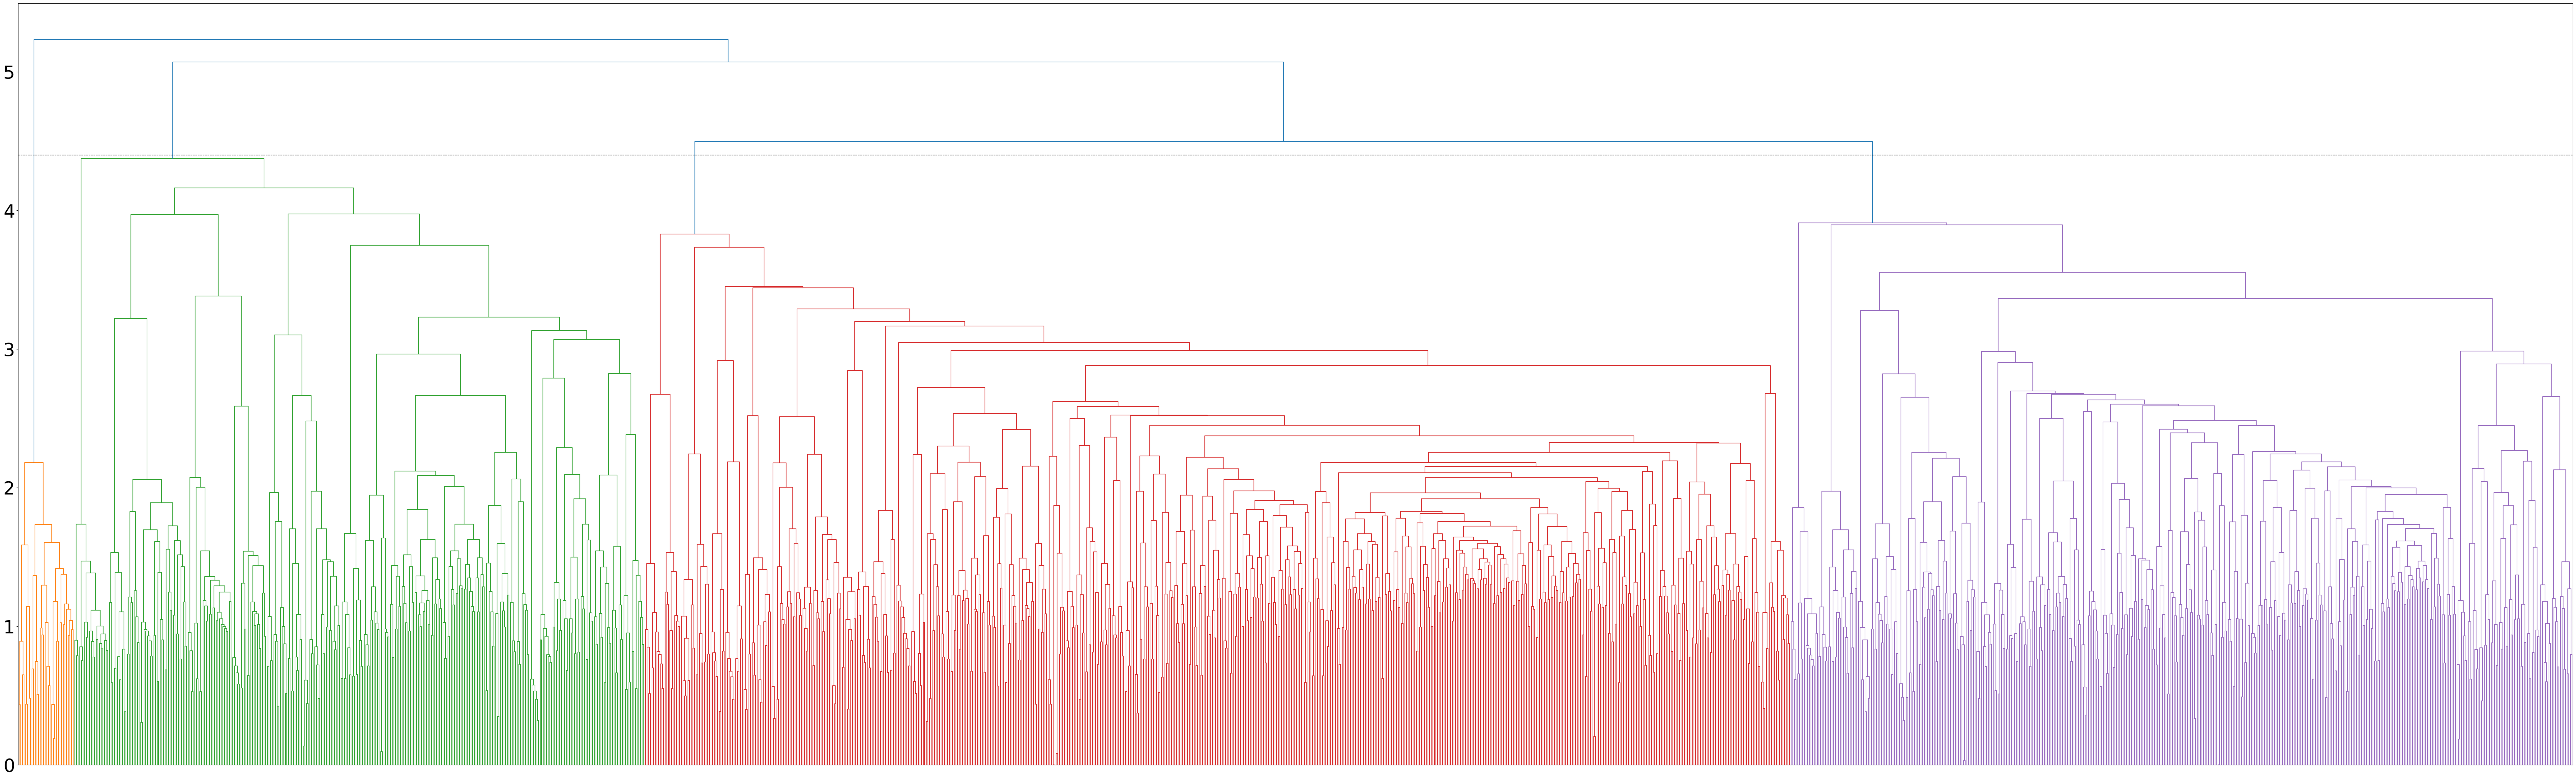

In [ ]:
# 계층적 군집화
clusters = linkage(X_train_tfidf.toarray(), "ward")

# 덴드로그램 생성과 표시
plt.figure(figsize=(100,30))

# matplotlib의 rcParams 설정을 활용하면, 차트의 크기와 선의 색, 두께등의 기본 값을 설정 가능
# parameters = {'ytick.labelsize': 40}
# plt.rcParams.update(parameters)

plt.yticks(fontsize=40)

# tree = dendrogram(clusters)
# tree = dendrogram(clusters, color_threshold=4.4)  # color_threshold 수치를 바꿔가며 그려보기

tree = dendrogram(clusters, labels=fileids, leaf_rotation=90., leaf_font_size=10., color_threshold=4.4)
# color_threshold 수치를 바꿔가며 그려보기

plt.axhline(y=4.4, color='black', linewidth=1, linestyle='dashed')
plt.show()

In [ ]:
memb = fcluster(linkage(X_train_tfidf.toarray(), "ward"), 4, criterion='maxclust')
# 같은 클러스터 안의 두 레코드간 거리가 r 보다 크지 않으면서 전체 클러스터 수가 4개 이하가 되는 minimum threshold r 을 찾음
# membership 반환

memb = pd.Series(memb, index=fileids)

# added
print(memb)

for key, item in memb.groupby(memb):
    print('-'*100)
    print(key, ': ', ', '.join(item.index[:20]))

    3
    3
    4
    4
    3
   ..
    2
    3
    3
    2
    3
Length: 1554, dtype: int32
----------------------------------------------------------------------------------------------------
1 :  , , , , , , , , , , , , , , , , , , , 
----------------------------------------------------------------------------------------------------
2 :  , , , , , , , , , , , , , , , , , , , 
----------------------------------------------------------------------------------------------------
3 :  , , , , , , , , , , , , , , , , , , , 
----------------------------------------------------------------------------------------------------
4 :  , , , , , , , , , , , , , , , , , , , 


## 2. 비계층적 군집화

In [ ]:
# 비계층적 군집화
from sklearn.cluster import KMeans

# 특징(단어) 목록 얻기
features = tfidf.get_feature_names_out()

# 비계층적(K-means) 군집화
K = 4   # 군집 수 설정
km = KMeans(K, init="k-means++")
# ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence

km.fit(X_train_tfidf)

print("centers: " , km.cluster_centers_)
print(type(km.cluster_centers_))

# 센트로이드 역순 간접 정렬
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

for cluster_num in range(K):
    #center_word_nums = [word_num for word_num in ordered_centroids[cluster_num, :]]
    center_word_nums = []  # 클러스터 중심 단어 번호
    for word_num in ordered_centroids[cluster_num, :]:
        center_word_nums.append(word_num)

    # center_words = [features[word_num] for word_num in center_word_nums]
    center_words = []   # 클러스터 중심 단어
    for word_num in center_word_nums:
        word = features[word_num]
        center_words.append(word)

    print("군집 {}: {}".format(cluster_num, ", ".join(center_words[:20])))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


centers:  [[1.48544304e-03 2.50260386e-03 6.96111444e-04 ... 4.19983455e-03
  1.13715251e-04 1.21792375e-04]
 [1.25323514e-03 5.50897447e-03 0.00000000e+00 ... 0.00000000e+00
  1.77743776e-01 1.19954027e-01]
 [2.88648199e-03 1.62708333e-03 2.43797751e-04 ... 7.81041834e-05
  0.00000000e+00 0.00000000e+00]
 [8.87604630e-03 4.22319951e-03 1.95266834e-03 ... 0.00000000e+00
  1.16835771e-03 1.02687964e-04]]
<class 'numpy.ndarray'>
군집 0: graphics, university, com, thanks, posting, host, nntp, files, image, file, help, need, program, know, looking, windows, computer, does, version, mail
군집 1: henry, toronto, zoo, spencer, zoology, work, utzoo, kipling, man's, article, launch, umd, orbit, cost, eng, lunar, development, space, titan, costs
군집 2: com, god, sandvik, jesus, people, christian, article, don't, morality, kent, know, objective, say, bible, just, apple, christians, think, koresh, brian
군집 3: space, nasa, access, gov, com, digex, alaska, moon, pat, article, just, orbit, like, sci, shut

In [ ]:
### check!

import numpy as np

test = np.array([[3, 4, 2, 1],
       [6, 2, 9, 3]])

print(test.argsort())
test.argsort()[:, ::-1]  # 행을 기준으로 내림차순으로

[[3 2 0 1]
 [1 3 0 2]]


array([[1, 0, 2, 3],
       [2, 0, 3, 1]])